# About this Notebook

The purpose of this notebook is to see and compare the performance of the different models used.

# Table of Contents

* [1 - How to train the models](#1)
* [2 - Import of data](#2)
* [3 - Preprocessing](#3)
    * [3.1 - Parameters](#3.1)
    * [3.2 - Tolles-Lawson compensation](#3.2)
    * [3.3 - IGRF and diurnal correction](#3.3)
    * [3.4 - Feature selection](#3.4)
    * [3.5 - Data scaling](#3.5)
* [4 - Model result](#4)
    * [4.1 - Inference](#4.1)
    * [4.2 - Error per lines](#4.2)
    * [4.3 - Error map](#4.3)
* [5 - More insights on the model](#5)

# Setup

In [1]:
import os
# Move from notebooks to MagNav
print(os.getcwd())
os.chdir('../')
print(os.getcwd())

/mnt/a/Documents/GitHub/MagNav/notebooks
/mnt/a/Documents/GitHub/MagNav


In [2]:
import sys
sys.path.insert(0,'./src')

# Import packages

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import widgets, GridspecLayout

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tabulate import tabulate
from tqdm.notebook import tqdm_notebook
import random
import magnav
import os

import ast
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import joblib
import matplotlib.pyplot as plt
import matplotlib.animation
import shap
import psutil

In [4]:
import seaborn as sns
sns.set_theme(palette=sns.color_palette("bright"))

In [5]:
# Reproducibility
torch.manual_seed(27)
random.seed(27)
np.random.seed(27)

# 1 - How to train the models

There are already pre-trained models provided with the Github folder in ```models```. However, if you want to test other parameters than the ones already tested, you can train the models with the ```train.py``` script in the ```src``` folder. Run this script from the terminal and type ```--help``` to get the list of parameters to use. Here is an example under windows but it works the same way under Linux : <br><br>
![coordinate_system](../data/external/Images/trainpy.png)

# 2 - Import of data

In [6]:
flights = {}

# Flights to import
flights_num = [2,3,4,6,7]

for n in flights_num:
    df = pd.read_hdf('./data/processed/Flt_data.h5', key=f'Flt100{n}')
    flights[n] = df

print(f'Data import done. Memory used {psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2:.2f} Mb')

Data import done. Memory used 1015.54 Mb


# 3 - Preprocessing

This section allows to select the model according to the desired parameters, it is also necessary to choose on which flights/sections our model should be tested.

## 3.1 - Parameters

In [8]:
# Widgets
top_left=widgets.Checkbox(value=True,description='Tolles-Lawson')
top_right=widgets.Dropdown(options=[('No corrections',0),('IGRF correction',1),('Diurnal correction',2),('IGRF+Diurnal correction',3)],value=3,description='Correction')
bottom_left=widgets.Text(value='IGRFMAG1',placeholder='Magnetometer used as truth',description='Truth')
bottom_right=widgets.Dropdown(options=[('No scaling',0),('Standard scaling',1),('Min-Max scaling (-1,1)',2)],value=1,description='Data scaling')
bottom = widgets.Dropdown(options=['MLP','CNN','LSTM'], value='CNN',description='Model')
grid = GridspecLayout(3, 2, width='700px')
grid[0,0] = top_left; grid[0,1] = top_right; grid[1,0] = bottom_left; grid[1,1] = bottom_right; grid[2,:] = bottom
grid

GridspecLayout(children=(Checkbox(value=True, description='Tolles-Lawson', layout=Layout(grid_area='widget001'…

In [9]:
# Get widgets values
TL = top_left.value
COR = top_right.value
TRUTH = bottom_left.value
SCALING = bottom_right.value
MODEL = bottom.value
DEVICE = 'cpu'

if SCALING==0: sc='None'
elif SCALING==1: sc='std'
elif SCALING==2: sc='minmax'
model_path = f'{MODEL}_{sc}_TL{int(TL)}_COR{COR}_{TRUTH}'

# Test sections/flights, change it to test the model on other data
test_lines  = [flights[7].LINE.unique().tolist(),
               flights[3].LINE.unique().tolist()]

# Import models
from src.models.CNN import Optuna_CNN
models = {}
for n in range(len(test_lines)):
    models[n] = torch.load(f'models/{model_path}/{MODEL}_fold{n}.pt')
    if MODEL == 'LSTM':
        models[n].device = DEVICE

In [10]:
# Get model parameters
params = pd.read_csv(f'models/{model_path}/parameters.csv')
SEQ_LEN = int(params.loc[0,'seq_len'])
BATCH_SIZE = int(params.loc[0,'batch_size'])

## 3.2 - Tolles-Lawson compensation

In [11]:
# Get cloverleaf pattern data
mask = (flights[2].LINE == 1002.20)
tl_pattern = flights[2][mask]

# filter parameters
fs      = 10.0
lowcut  = 0.1
highcut = 0.9
filt    = ['Butterworth',4]

if TL == 1:
    for n in tqdm_notebook(flights_num):

        # A matrix of Tolles-Lawson
        A = magnav.create_TL_A(flights[n]['FLUXB_X'],flights[n]['FLUXB_Y'],flights[n]['FLUXB_Z'])

        # Tolles Lawson coefficients computation
        TL_coef_2 = magnav.create_TL_coef(tl_pattern['FLUXB_X'],tl_pattern['FLUXB_Y'],tl_pattern['FLUXB_Z'],tl_pattern['UNCOMPMAG2'],
                                      lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt, ridge=0.025)
        TL_coef_3 = magnav.create_TL_coef(tl_pattern['FLUXB_X'],tl_pattern['FLUXB_Y'],tl_pattern['FLUXB_Z'],tl_pattern['UNCOMPMAG3'],
                                      lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt, ridge=0.025)
        TL_coef_4 = magnav.create_TL_coef(tl_pattern['FLUXB_X'],tl_pattern['FLUXB_Y'],tl_pattern['FLUXB_Z'],tl_pattern['UNCOMPMAG4'],
                                      lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt, ridge=0.025)
        TL_coef_5 = magnav.create_TL_coef(tl_pattern['FLUXB_X'],tl_pattern['FLUXB_Y'],tl_pattern['FLUXB_Z'],tl_pattern['UNCOMPMAG5'],
                                      lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt, ridge=0.025)

        # Magnetometers correction
        flights[n]['TL_comp_mag2_cl'] = magnav.apply_TL(np.reshape(flights[n]['UNCOMPMAG2'].tolist(),(-1,1)), TL_coef_2, A)
        flights[n]['TL_comp_mag3_cl'] = magnav.apply_TL(np.reshape(flights[n]['UNCOMPMAG3'].tolist(),(-1,1)), TL_coef_3, A)
        flights[n]['TL_comp_mag4_cl'] = magnav.apply_TL(np.reshape(flights[n]['UNCOMPMAG4'].tolist(),(-1,1)), TL_coef_4, A)
        flights[n]['TL_comp_mag5_cl'] = magnav.apply_TL(np.reshape(flights[n]['UNCOMPMAG5'].tolist(),(-1,1)), TL_coef_5, A)

else:
    print(f'No Tolles-Lawson correction done. Memory used {psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2:.2f} Mb')

  0%|          | 0/5 [00:00<?, ?it/s]

## 3.3 - IGRF and diurnal correction

In [12]:
from src.train import apply_corrections, Standard_scaling, MinMax_scaling

In [13]:
flights_cor = {}

if TL == 1:
    mags_to_cor = ['TL_comp_mag4_cl', 'TL_comp_mag5_cl']
else:
    mags_to_cor = ['UNCOMPMAG4', 'UNCOMPMAG5']

if COR == 0:
    flights_cor = flights.copy()
    del flights
    print(f'No correction done. Memory used {psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2:.2f} Mb')
if COR == 1:
    for n in tqdm_notebook(flights_num):
        flights_cor[n] = apply_corrections(flights[n], mags_to_cor, diurnal=False, igrf=True)
    del flights
    print(f'IGRF correction done. Memory used {psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2:.2f} Mb')
if COR == 2: 
    for n in tqdm_notebook(flights_num):
        flights_cor[n] = apply_corrections(flights[n], mags_to_cor, diurnal=True, igrf=False)
    del flights
    print(f'Diurnal correction done. Memory used {psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2:.2f} Mb')
if COR == 3:
    for n in tqdm_notebook(flights_num):
        flights_cor[n] = apply_corrections(flights[n], mags_to_cor, diurnal=True, igrf=True)
    del flights
    print(f'IGRF+Diurnal correction done. Memory used {psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2:.2f} Mb')

  0%|          | 0/5 [00:00<?, ?it/s]

IGRF+Diurnal correction done. Memory used 1261.85 Mb


## 3.4 - Feature selection

In [14]:
# Always keep the 'LINE' feature in the feature list so that the MagNavDataset function can split the flight data. The list of features should match with the features used for training.
features = [mags_to_cor[0],mags_to_cor[1],'V_BAT1','V_BAT2',
                    'INS_VEL_N','INS_VEL_V','INS_VEL_W','CUR_IHTR','CUR_FLAP','CUR_ACLo','CUR_TANK','PITCH','ROLL','AZIMUTH','BARO','LINE',TRUTH]

dataset = {}

for n in flights_num:
    dataset[n] = flights_cor[n][features]

print(f'Feature selection done. Memory used {psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2:.2f} Mb')

Feature selection done. Memory used 1307.55 Mb


## 3.5 - Data scaling

In [15]:
if SCALING == 0:
    df = pd.DataFrame()
    for flight in flights_num:
        df = pd.concat([df,dataset[flight]], ignore_index=True, axis=0)

    # Save scaling parameters
    scaling = {}
    for n in range(len(test_lines)):
        scaling[n] = ['None']

elif SCALING == 2:
    # Save scaling parameters
    bound = [-1,1]
    scaling = {}
    df = pd.DataFrame()
    for flight in flights_num:
        df = pd.concat([df,dataset[flight]], ignore_index=True, axis=0)
    for n in range(len(test_lines)):
        mask = pd.Series(dtype=bool)
        for line in test_lines[n]:
            temp_mask = (df.LINE == line)
            mask = temp_mask|mask
        scaling[n] = ['minmax', bound[0], bound[1], df.loc[mask,TRUTH].min(), df.loc[mask,TRUTH].max()]
    del mask, temp_mask, df

    # Apply Min-Max sacling to the dataset
    for n in tqdm_notebook(flights_num):
        dataset[n] = MinMax_scaling(dataset[n], bound=bound)
    df = pd.DataFrame()
    for flight in flights_num:
        df = pd.concat([df,dataset[flight]], ignore_index=True, axis=0)

elif SCALING == 1:
    # Save scaling parameters
    scaling = {}
    df = pd.DataFrame()
    for flight in flights_num:
        df = pd.concat([df,dataset[flight]], ignore_index=True, axis=0)
    for n in range(len(test_lines)):
        mask = pd.Series(dtype=bool)
        for line in test_lines[n]:
            temp_mask = (df.LINE == line)
            mask = temp_mask|mask
        scaling[n] = ['std', df.loc[mask,TRUTH].mean(), df.loc[mask,TRUTH].std()]
    del mask, temp_mask, df

    # Apply Standard scaling to the dataset
    for n in tqdm_notebook(flights_num):
        dataset[n] = Standard_scaling(dataset[n])
    df = pd.DataFrame()
    for flight in flights_num:
        df = pd.concat([df,dataset[flight]], ignore_index=True, axis=0)

del dataset
print(f'Data scaling done. Memory used {psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2:.2f} Mb')

  0%|          | 0/5 [00:00<?, ?it/s]

Data scaling done. Memory used 1295.02 Mb


# 4 - Model result

## 4.1 - Inference

The following cells display the prediction of the model as well as the error compared to the truth.

In [16]:
from src.train import trim_data, MagNavDataset

In [18]:
pred_traj = {}
test_traj = {}
RMSE = {}

for fold in range(len(test_lines)):
    model = models[fold].to(DEVICE)
    test = MagNavDataset(df, seq_len=SEQ_LEN, split='test', train_lines=[], test_lines=test_lines[fold], truth=TRUTH)
    test_loader    = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

    preds = []

    # Disable layers specific to training such as Dropout/BatchNorm
    model.eval()

    # Turn off gradients computation
    with torch.no_grad():

        for batch_index, (inputs, labels) in enumerate(test_loader):

            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # Make prediction for this batch
            predictions = model(inputs)

            # Save prediction for this batch
            preds.append(predictions.cpu())

        preds = np.concatenate(preds)
    
    # Descale the features
    scaling_fold = scaling[fold]
    if scaling_fold[0] == 'None':
        pred_traj[fold] = preds
        test_traj[fold] = test.y[SEQ_LEN:].numpy()
        RMSE[fold] = magnav.rmse(pred_traj[fold],test_traj[fold],False)
    elif scaling_fold[0] == 'std':
        pred_traj[fold] = preds*scaling_fold[2]+scaling_fold[1]
        test_traj[fold] = test.y[SEQ_LEN:].numpy()*scaling_fold[2]+scaling_fold[1]
        RMSE[fold] = magnav.rmse(pred_traj[fold],test_traj[fold],False)
    elif scaling_fold[0] == 'minmax':
        pred_traj[fold] = scaling_fold[3]+((preds-scaling_fold[1])*(scaling_fold[4]-scaling_fold[3])/(scaling_fold[2]-scaling_fold[1]))
        test_traj[fold] = scaling_fold[3]+((test.y[SEQ_LEN:].numpy()-scaling_fold[1])*(scaling_fold[4]-scaling_fold[3])/(scaling_fold[2]-scaling_fold[1]))
        RMSE[fold] = magnav.rmse(pred_traj[fold],test_traj[fold],False)

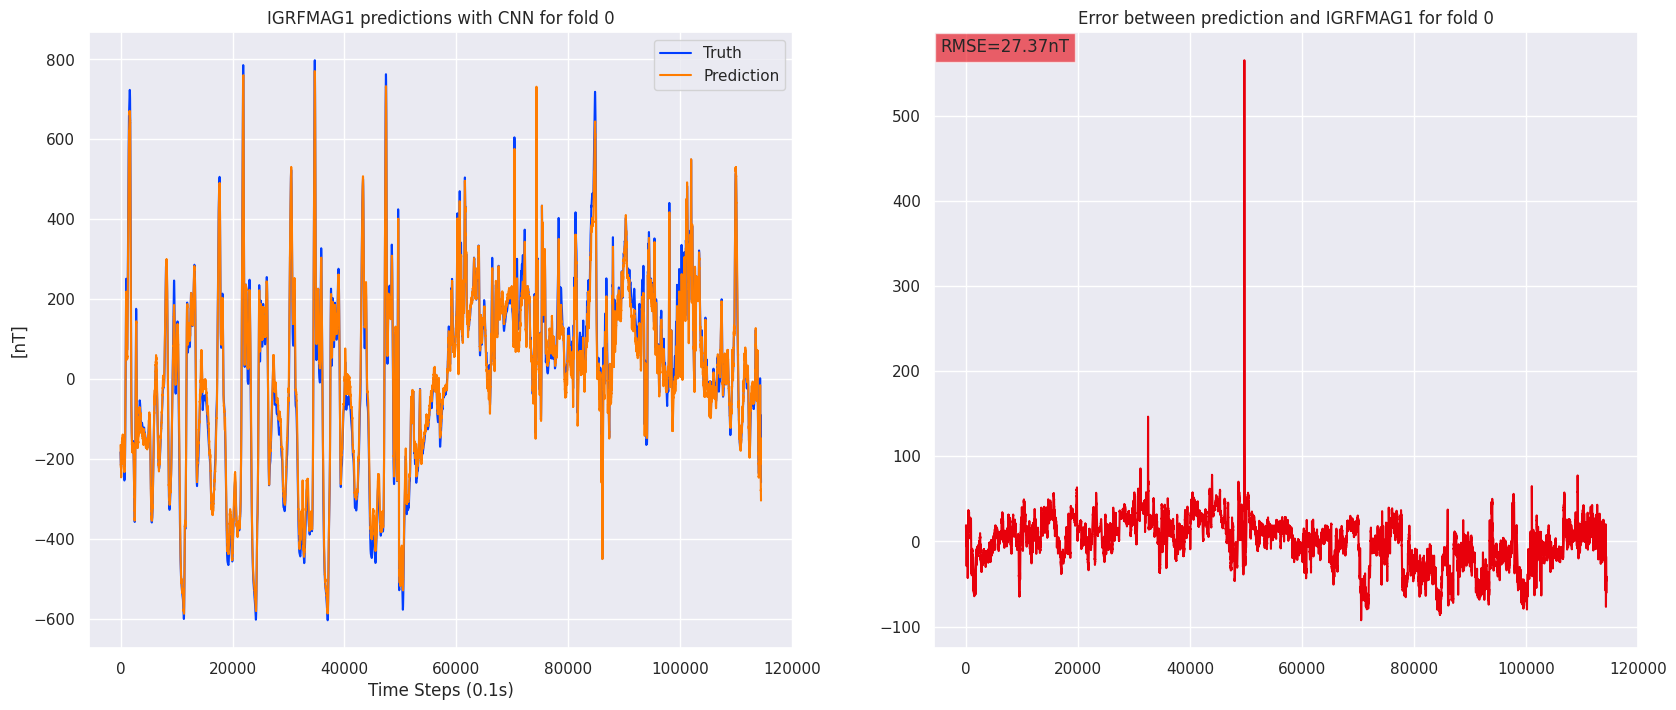

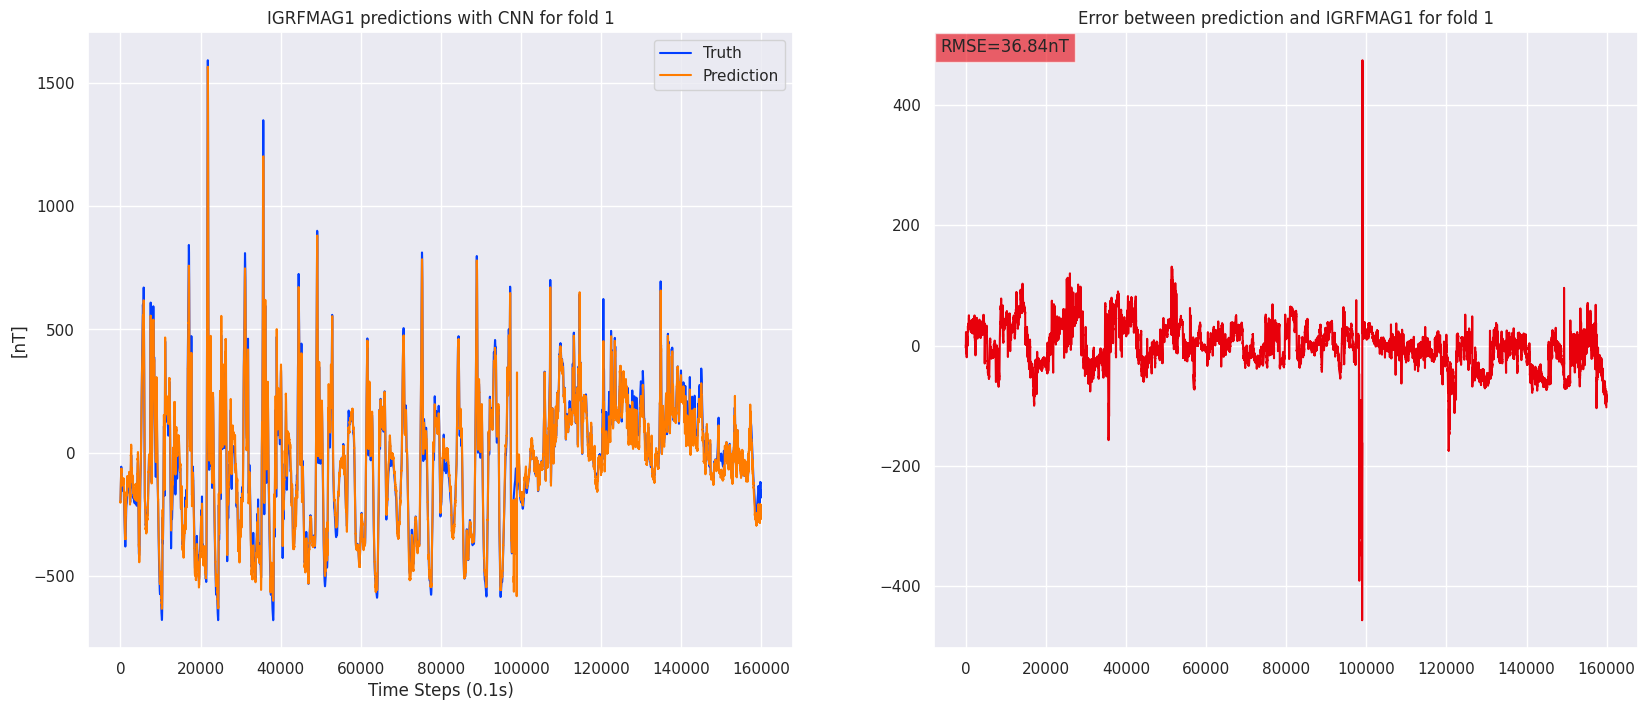

In [19]:
# Plot the results
for fold in range(len(test_lines)):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=[20,8])
    ax1.plot(test_traj[fold],label='Truth',color='C0');ax1.plot(pred_traj[fold],label='Prediction',color='C1')
    ax1.set_title(f'{TRUTH} predictions with {MODEL} for fold {fold}');ax2.set_title(f'Error between prediction and {TRUTH} for fold {fold}')
    ax1.set_xlabel('Time Steps (0.1s)');ax1.set_ylabel('[nT]')
    ax2.plot(pred_traj[fold]-test_traj[fold],'C3')
    ax2.text(0.009,0.9679,f'RMSE={RMSE[fold]:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C3',alpha=0.6),transform=plt.gca().transAxes)
    ax1.legend()
    plt.show()

## 4.2 - Error per lines

The following cells display the model prediction error for each test section.

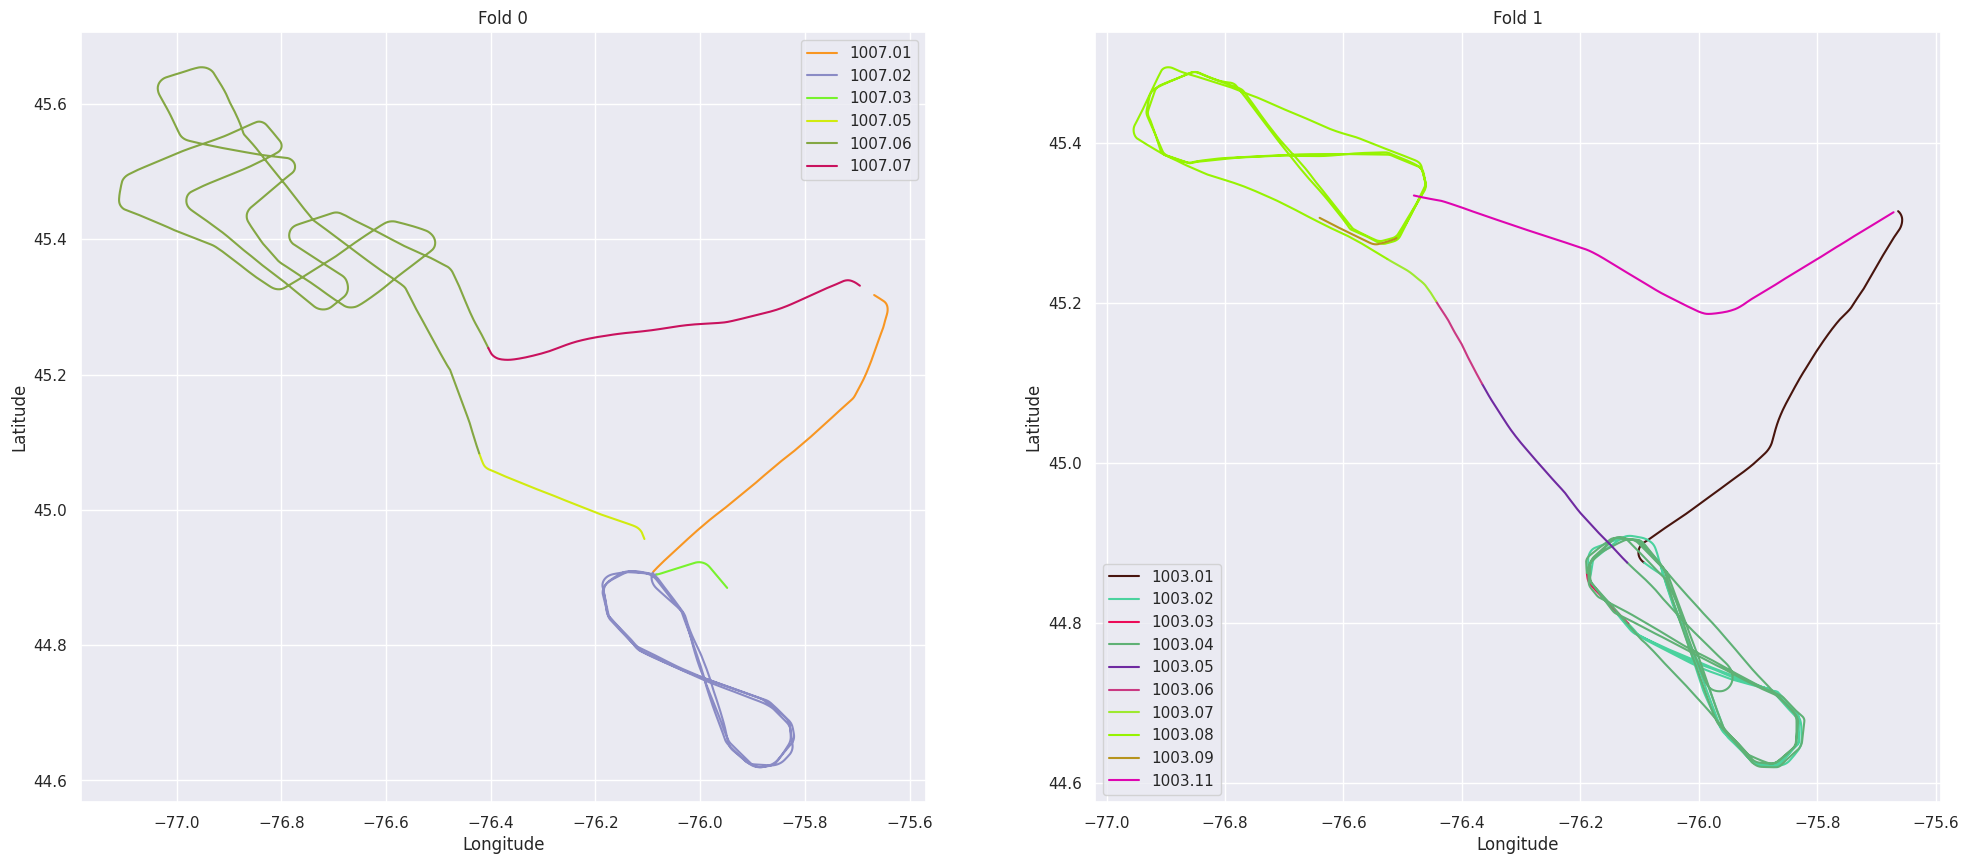

this method is deprecated in favour of `Styler.hide(axis="index")`


In [18]:
table = pd.DataFrame()
for fold in range(len(test_lines)):
    header = [np.array([f'Fold {fold}',f'Fold {fold}']), np.array(['Line number','RMSE [nT]'])]
    fold_table = pd.DataFrame(columns = header)
    for n,line in enumerate(test_lines[fold]):
        mask = pd.Series(dtype=bool)
        mask = df.LINE == line
        idx = df.loc[mask,TRUTH].index.to_list()-df.loc[mask,TRUTH].index[0]
        pred_line = pred_traj[fold][idx]
        true_line = test_traj[fold][idx]
        RMSE = magnav.rmse(pred_line,true_line)
        fold_table.loc[n,(f'Fold {fold}','Line number')] = '{:.2f}'.format(line)
        fold_table.loc[n,(f'Fold {fold}','RMSE [nT]')] = '{:.2f}'.format(RMSE)
    table = pd.concat([table,fold_table], axis=1)
table = table.where(pd.notnull(table), '')

df_full = pd.DataFrame()
for flight in flights_num:
    df_full = pd.concat([df_full,flights_cor[flight]], ignore_index=True, axis=0)
    
fig = plt.figure(figsize=[24,10])
for fold in range(len(test_lines)):
    ax = fig.add_subplot(1,len(test_lines),fold+1)
    mask = pd.Series(dtype=bool)
    for line in test_lines[fold]:
        temp_mask = (df_full.LINE == line)
        long_test = df_full.loc[temp_mask,'LONG']
        lat_test = df_full.loc[temp_mask,'LAT']
        ax.plot(long_test,lat_test,color=magnav.get_random_color(),label=line)
    ax.set_xlabel('Longitude'), ax.set_ylabel('Latitude'), ax.set_title(f'Fold {fold}')
    plt.legend()
plt.show()
table.style.hide_index()

## 4.3 - Error map

The following cells display the prediction error as a function of latitude and longitude.

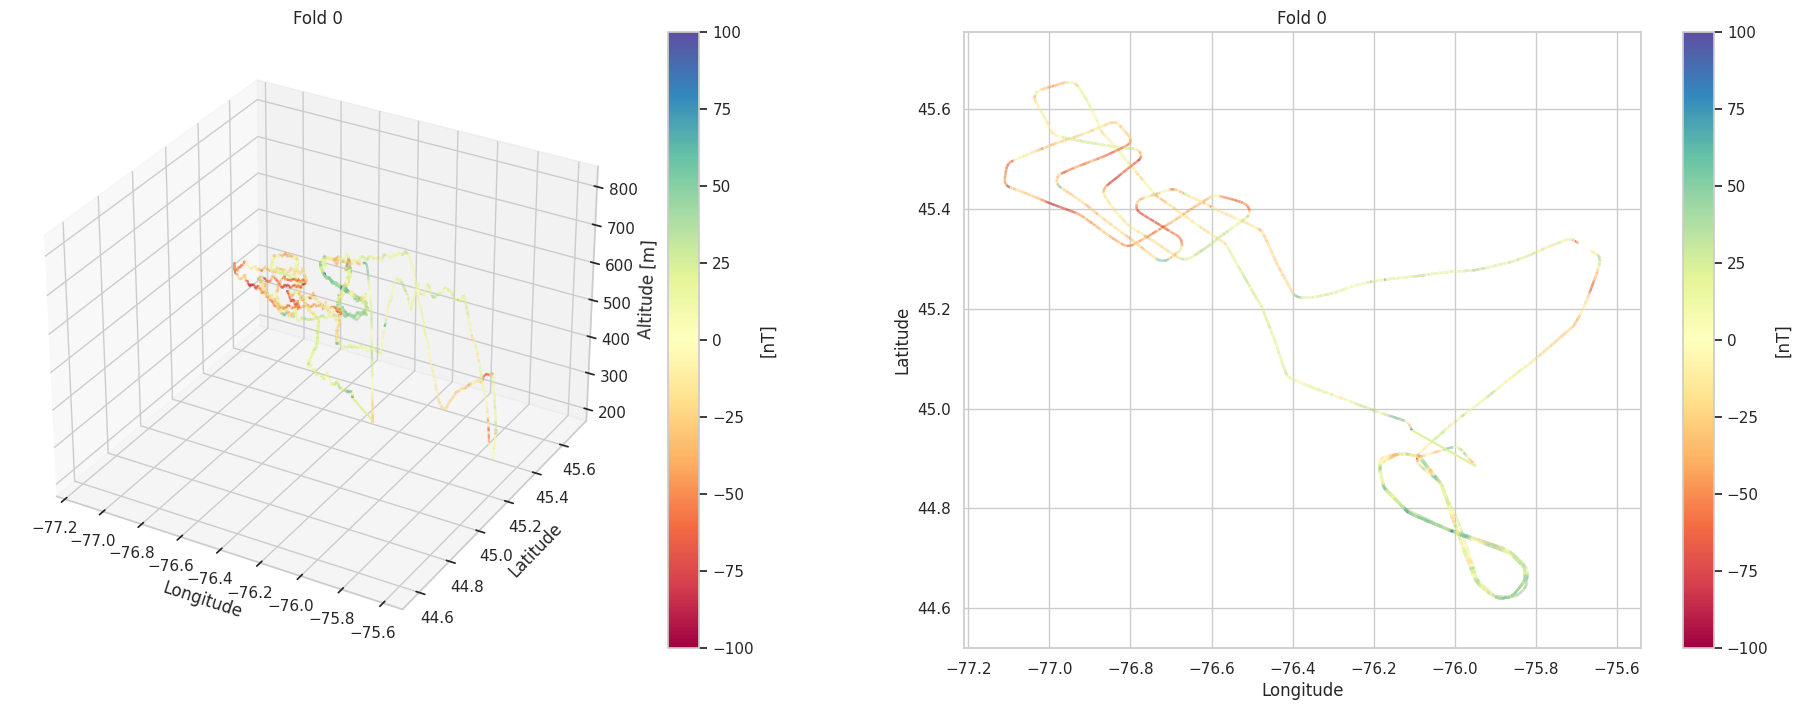

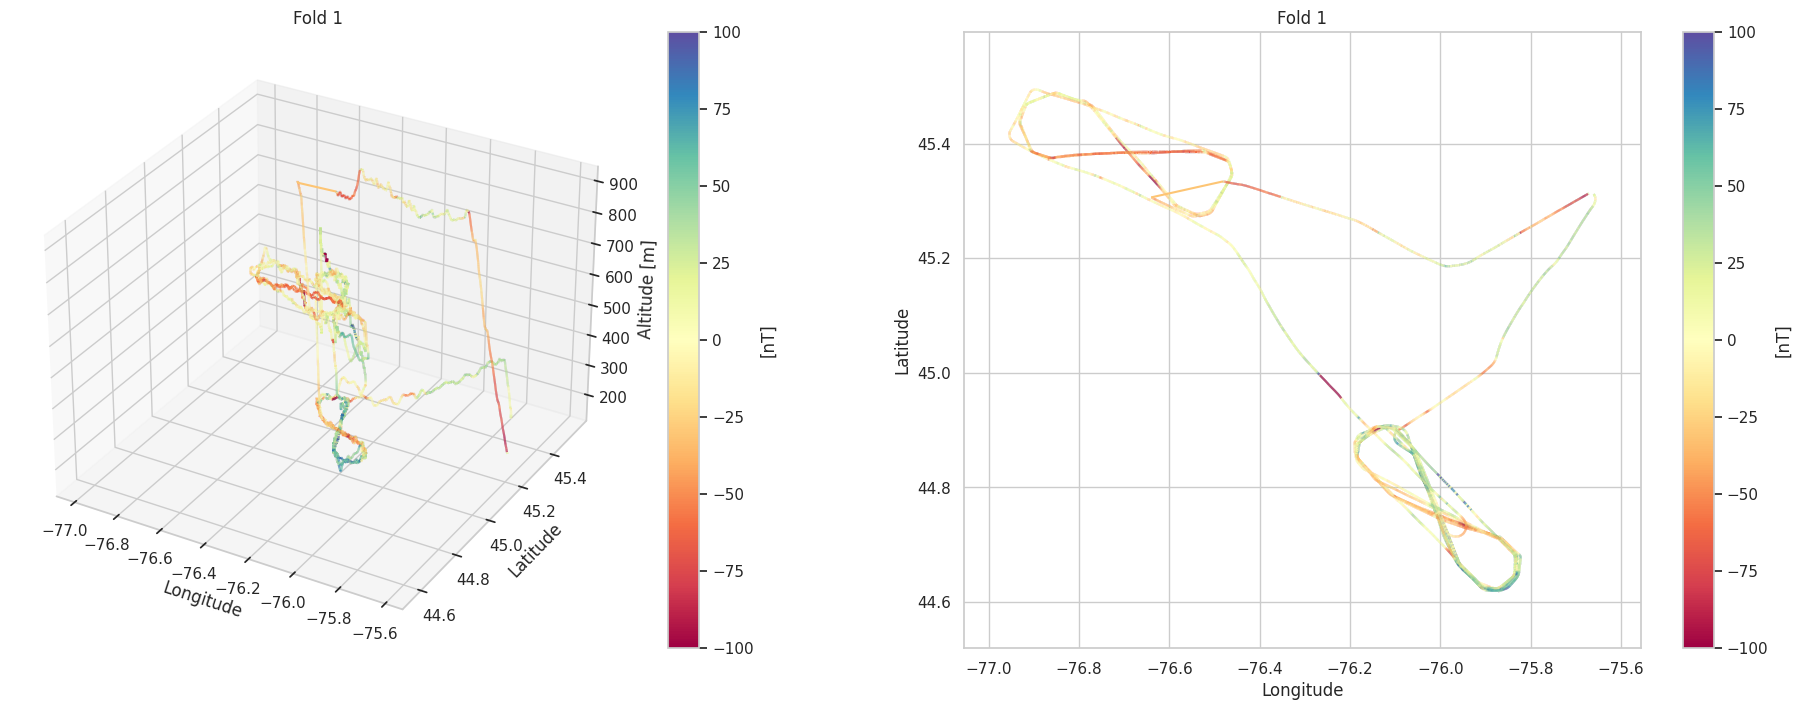

In [19]:
sns.set_style('whitegrid')

for fold in range(len(test_lines)):
    mask = pd.Series(dtype=bool)
    for line in test_lines[fold]:
        temp_mask = (df_full.LINE == line)
        mask = temp_mask|mask

    long_test = df_full.loc[mask,'LONG']
    lat_test = df_full.loc[mask,'LAT']
    altitude = df_full.loc[mask,'BARO']
    
    # 3D plot
    points = np.array([long_test[SEQ_LEN:],lat_test[SEQ_LEN:],altitude[SEQ_LEN:]]).T.reshape(-1,1,3)
    segments = np.concatenate([points[:-1],points[1:]],axis=1)

    fig = plt.figure(figsize=[24,8])
    ax = fig.add_subplot(1,2,1,projection='3d')

    error = pred_traj[fold]-test_traj[fold]

    lc = Line3DCollection(segments,cmap=plt.get_cmap('Spectral'))
    lc.set_array(error.reshape(-1))
    lc.set_clim(vmin=-100,vmax=100)
    ax.add_collection(lc)

    cbar = plt.colorbar(lc,ax=ax,label='[nT]')

    ax.set_xlim(min(long_test)-0.1,max(long_test)+0.1)
    ax.set_ylim(min(lat_test)-0.1,max(lat_test)+0.1)
    ax.set_zlim(min(altitude)-0.1,max(altitude)+0.1)
    ax.set_xlabel('Longitude'), ax.set_ylabel('Latitude'), ax.set_zlabel('Altitude [m]'), ax.set_title(f'Fold {fold}')
    
    # 2D plot
    points = np.array([long_test[SEQ_LEN:],lat_test[SEQ_LEN:]]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1],points[1:]],axis=1)

    ax = fig.add_subplot(1,2,2)

    error = pred_traj[fold]-test_traj[fold]

    lc = LineCollection(segments,cmap=plt.get_cmap('Spectral'))
    lc.set_array(error.reshape(-1))
    lc.set_clim(vmin=-100,vmax=100)
    ax.add_collection(lc)

    cbar = plt.colorbar(lc,ax=ax,label='[nT]')

    ax.set_xlim(min(long_test)-0.1,max(long_test)+0.1)
    ax.set_ylim(min(lat_test)-0.1,max(lat_test)+0.1)
    ax.set_xlabel('Longitude'), ax.set_ylabel('Latitude'), ax.set_title(f'Fold {fold}')

    plt.show()
sns.set_theme(palette=sns.color_palette("bright"))

# 5 - More insights on the model

The following cells display the activation of the model gradients for the different input variables of the model.

In [119]:
time_step = 3500

In [120]:
model = models[0].to(DEVICE)
test = MagNavDataset(df, seq_len=SEQ_LEN, split='test', train_lines=[], test_lines=test_lines[0], truth=TRUTH)
test_loader = DataLoader(test,
                       batch_size=20000,
                       shuffle=False,
                       num_workers=0,
                       pin_memory=False)
batch = next(iter(test_loader))
seqs, _ = batch
e = shap.GradientExplainer(model,seqs)
varss = seqs[time_step:time_step+600,:,:]
shap_values = e.shap_values(varss)

In [121]:
%%capture
%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"
import numpy as np
import math

frames = 50

fig, ax = plt.subplots(figsize=[20,5])
ax.set_yticks(range(len(features[:-2])))
ax.set_yticklabels(features[:-2],fontsize=14)

plt.text(30,18,'Time step (1 time step = 0.1 seconds)', fontsize=14)
ax.grid(False)

def animate(i):
    ax.imshow(abs(shap_values[i,:,:]),cmap='Reds')

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=frames, interval=500)

In [122]:
# Take a long time
ani

In [24]:
# Export to GIF, uncomment to export
# writegif = matplotlib.animation.PillowWriter(fps=5)
# ani.save('cnnanim.gif',writer=writegif)